# 理解线性回归很容易，但选特征很难

比如，我们想研究小黑「出门是否购买补刀斧」对「20分钟经济」的影响，需要控制哪些特征？

比如段位？分路？20分钟kda？推搭数？6分钟正补数？...

- 哪些特征必须被控制？
- 控制的特征是不是越多越好？会不会有些特征控制了，反而有坏处？

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().absolute().parents[0]))
import pandas as pd
import requests
from sqlalchemy import create_engine
from sqlalchemy.pool import NullPool
from utils import get_db_engine, get_proxies, get_api_json, parallel_run_api, get_hero_sample_match

dota2_hero_df = pd.read_sql("select * from hero", con=get_db_engine())
dota2_hero_id_to_name = { str(r['hero_id']): r['hero_name'] for _, r in dota2_hero_df.iterrows() }
dota2_hero_name_to_id = { r['hero_name']: str(r['hero_id']) for _, r in dota2_hero_df.iterrows() }
dota2_hero_df.head(1)

,hero_id,ingame_name,en_official_name,primary_attr,attack_type,roles,legs,en_name,hero_name
0,1,npc_dota_hero_antimage,Anti-Mage,agi,Melee,"{Carry,Escape,Nuker}",2,antimage,敌法师


In [100]:
hero_match_df = get_hero_sample_match(dota2_hero_name_to_id["卓尔游侠"], 10000)
len(hero_match_df.index)

10000

In [ ]:
len(hero_match_df.match_id.to_list())

In [ ]:
match_json = get_api_json(f"https://api.opendota.com/api/matches/6305814124", loop=False)

In [1]:
# import requests
# from sqlalchemy import create_engine
# from sqlalchemy.pool import NullPool
# from utils import get_db_engine, get_proxies, get_api_json, parallel_run_api, get_hero_sample_match

# def get_hero_battle_info(match_id, proxy = None):
#     try:
#         match_json = get_api_json(f"https://api.opendota.com/api/matches/{match_id}", loop=False, proxy=proxy)
#         if match_json["version"] is None:
#             requests.post(f"https://api.opendota.com/api/request/{match_id}", proxies = proxy, timeout=2)
#             return (None, None)
#         row_dicts = []
#         for p in match_json["players"]:
#             row_dict = {}
#             for c in ["match_id", "hero_id", "rank_tier", "party_size", "creeps_stacked", "camps_stacked", "gold_per_min", "total_gold",
#                       "firstblood_claimed",
#                       "randomed", "repicked"]:
#                 row_dict[c] = p[c]
#             row_dict["skill"] = match_json["skill"]
#             row_dict["camp"] = "radiant" if p["isRadiant"] is True else "dire"
#             row_dict["hero_name"] = dota2_hero_id_to_name[str(p["hero_id"])]
#             lane_role_dict = {1: "safe", 2: "mid", 3: "off", 4: "jungle"}
#             row_dict["lane_role"] = lane_role_dict[p["lane_role"]] if p["lane_role"] in lane_role_dict else "unknown"
#             row_dict["begin_buy_quelling_blade"] = 1 if "quelling_blade" in [ pl["key"] for pl in p["purchase_log"]  if pl["time"] < 0] else 0
#             row_dict["begin_buy_boots"] = 1 if "boots" in [ pl["key"] for pl in p["purchase_log"]  if pl["time"] < 0] else 0
#             row_dict["pick_order"] = [pb["order"] for pb in match_json["picks_bans"] if pb["is_pick"] is True and pb["hero_id"] == row_dict["hero_id"]][0]
#             row_dict["has_cosmetic"] = 1 if len([c["item_rarity"] for c in p["cosmetics"]]) > 0 else 0
#             row_dict["kills_20_min"] = len([kl["time"] for kl in p["kills_log"] if kl["time"] <= 1200])
#             row_dict["camp_gold_adv_20_min"] = match_json["radiant_gold_adv"][20] if row_dict["camp"] == "radiant" else -1 * match_json["radiant_gold_adv"][20]
#             row_dict["last_hits_6_min"] = p["lh_t"][6]
#             row_dict["deny_6_min"] = p["dn_t"][6]
#             row_dict["gold_20_min"] = p["gold_t"][6]
#             row_dict["xp_20_min"] = p["xp_t"][6]
            
#             row_dicts.append(row_dict)
#         r_df = pd.DataFrame(row_dicts)
#         return (r_df, match_id)
#     except Exception as e:
#         return (None, None)

# # get_hero_battle_info("6305814124")[0]

# r_df = parallel_run_api(get_hero_battle_info, hero_match_df.match_id.to_list(), min_proxy_count=4, complete_rate=1)
# # r_df = r_df[r_df["hero_id"].astype(str) == dota2_hero_name_to_id["卓尔游侠"]]


In [2]:
dr_df = pd.read_sql("select * from hero_dr_sample_info", con = get_db_engine())
dr_df.head(1)

,match_id,hero_id,rank_tier,party_size,creeps_stacked,camps_stacked,gold_per_min,total_gold,firstblood_claimed,randomed,...,begin_buy_quelling_blade,begin_buy_boots,pick_order,has_cosmetic,kills_20_min,camp_gold_adv_20_min,last_hits_6_min,deny_6_min,gold_20_min,xp_20_min
0,6306000587,40,None,3,0,0,427,16282,0,False,...,0,0,10,1,5,-11024,29,2,2071,1983


In [3]:
dr_df = dr_df[dr_df["hero_id"].astype(str) == dota2_hero_name_to_id["卓尔游侠"]]
dr_df

,match_id,hero_id,rank_tier,party_size,creeps_stacked,camps_stacked,gold_per_min,total_gold,firstblood_claimed,randomed,...,begin_buy_quelling_blade,begin_buy_boots,pick_order,has_cosmetic,kills_20_min,camp_gold_adv_20_min,last_hits_6_min,deny_6_min,gold_20_min,xp_20_min
4,6306000587,6,24.0,1,0,0,258,9838,1,False,...,1,0,7,1,2,-11024,27,0,2178,2885
15,6306988604,6,None,1,1,1,537,20218,0,False,...,1,0,3,1,4,-680,20,6,1649,2136
23,6306723982,6,None,1,0,0,547,25389,0,False,...,1,0,5,1,2,-10412,16,4,1530,1555
39,6305640027,6,63.0,2,6,3,419,13401,0,False,...,1,0,6,1,1,-3467,22,2,1567,1591
44,6306665566,6,24.0,2,2,1,752,30957,0,False,...,0,0,9,1,2,3359,13,7,1326,1737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19101,6305996104,6,None,1,5,2,583,25681,0,False,...,0,0,7,1,2,-2005,27,7,1962,1705
19115,6306762833,6,32.0,2,3,2,600,19010,0,False,...,1,0,7,1,5,5169,20,5,1994,2090
19122,6306508449,6,33.0,5,3,1,604,27794,0,False,...,1,0,6,0,2,-6028,21,2,1509,1765
19138,6305782992,6,64.0,5,0,0,719,29814,0,False,...,1,0,4,1,8,-3414,23,9,2145,1948


In [4]:
rank_dr_df = dr_df[~dr_df["rank_tier"].isna()]
rank_dr_df

,match_id,hero_id,rank_tier,party_size,creeps_stacked,camps_stacked,gold_per_min,total_gold,firstblood_claimed,randomed,...,begin_buy_quelling_blade,begin_buy_boots,pick_order,has_cosmetic,kills_20_min,camp_gold_adv_20_min,last_hits_6_min,deny_6_min,gold_20_min,xp_20_min
4,6306000587,6,24.0,1,0,0,258,9838,1,False,...,1,0,7,1,2,-11024,27,0,2178,2885
39,6305640027,6,63.0,2,6,3,419,13401,0,False,...,1,0,6,1,1,-3467,22,2,1567,1591
44,6306665566,6,24.0,2,2,1,752,30957,0,False,...,0,0,9,1,2,3359,13,7,1326,1737
67,6305906837,6,63.0,3,6,3,693,18734,1,False,...,1,0,8,1,5,10961,25,7,2198,1702
92,6306507084,6,43.0,3,9,5,623,35189,0,False,...,1,0,7,1,5,2521,20,7,1491,1636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19062,6306210642,6,54.0,2,26,7,640,24277,0,False,...,1,0,8,1,2,2626,27,1,1647,2604
19115,6306762833,6,32.0,2,3,2,600,19010,0,False,...,1,0,7,1,5,5169,20,5,1994,2090
19122,6306508449,6,33.0,5,3,1,604,27794,0,False,...,1,0,6,0,2,-6028,21,2,1509,1765
19138,6305782992,6,64.0,5,0,0,719,29814,0,False,...,1,0,4,1,8,-3414,23,9,2145,1948


# 直接做线性回归
T = treatment = 出门是否购买补刀斧

Y = result = 玩家第20分钟经济

In [26]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import graphviz as gr
%matplotlib inline

import seaborn as sns
sns.set_theme(style="whitegrid")

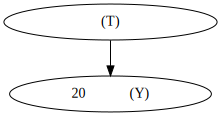

In [28]:
g = gr.Digraph()
g.edge("出门是否购买补刀斧(T)", "玩家第20分钟经济(Y)")
g

In [80]:
model_1 = smf.ols('gold_20_min ~ begin_buy_quelling_blade', data=rank_dr_df).fit()
model_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1572.4572,15.049,104.493,0.000,1542.921,1601.994
begin_buy_quelling_blade,115.7515,20.082,5.764,0.000,76.336,155.167


## 【应该控制的变量】混淆偏差confounding bias

所谓confounding（混淆、混杂），就是：既影响T，也影响Y，如果不控制住，就没法说清楚到底是T影响了Y，还是X影响了Y。目的是为了降低bias

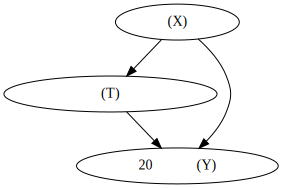

In [31]:
g = gr.Digraph()
g.edge("出门是否购买补刀斧(T)", "玩家第20分钟经济(Y)")
g.edge("天梯段位(X)", "出门是否购买补刀斧(T)")
g.edge("天梯段位(X)", "玩家第20分钟经济(Y)")
g

In [32]:
rank_dr_df["big_rank"] = rank_dr_df.rank_tier.astype(float).apply(lambda x: int(x / 10))

### 玩家段位越高，小黑出补刀斧的几率越高

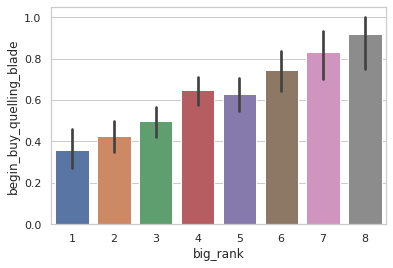

In [33]:
ax = sns.barplot(x="big_rank", y="begin_buy_quelling_blade", data=rank_dr_df)

### 玩家段位越高，小黑第20分钟经济越高

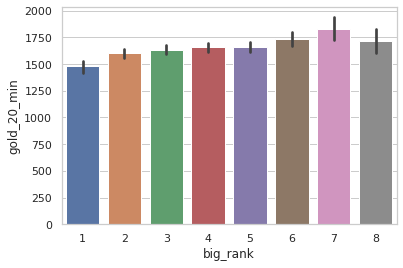

In [36]:
ax = sns.barplot(x="big_rank", y="gold_20_min", data=rank_dr_df)

In [16]:
model = smf.ols('gold_20_min ~ begin_buy_quelling_blade+rank_level', data=rank_dr_df).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1458.6255,25.576,57.031,0.000,1408.426,1508.825
begin_buy_quelling_blade,85.3652,20.520,4.160,0.000,45.089,125.642
rank_level,33.5962,6.156,5.457,0.000,21.513,45.679


## 【不应该控制的变量】选择性偏差selection bias

关键点：很明显是「出门是否购买补刀斧」影响「前6分钟补刀数」，而不是反过来

简单理解：出门买补刀斧 —— 前6分钟补刀数 —— 20分钟经济更高，这条路径本来就是成立的，出门买补刀斧提升前6分钟补刀数，进而提升20分钟经济。如果把前6分钟补刀数控制住，**反而是抹掉了这条因果关系的一些影响**。

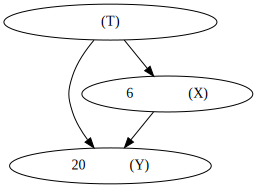

In [95]:
g = gr.Digraph()
g.edge("出门是否购买补刀斧(T)", "玩家第20分钟经济(Y)")
g.edge("出门是否购买补刀斧(T)", "前6分钟补刀数(X)")
g.edge("前6分钟补刀数(X)", "玩家第20分钟经济(Y)")
g

In [98]:
model = smf.ols('gold_20_min ~ begin_buy_quelling_blade', data=rank_dr_df).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1572.4572,15.049,104.493,0.000,1542.921,1601.994
begin_buy_quelling_blade,115.7515,20.082,5.764,0.000,76.336,155.167


In [99]:
model = smf.ols('gold_20_min ~ begin_buy_quelling_blade + last_hits_6_min', data=rank_dr_df).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,852.9044,22.544,37.832,0.000,808.655,897.153
begin_buy_quelling_blade,15.2680,13.115,1.164,0.245,-10.474,41.010
last_hits_6_min,38.2806,1.085,35.270,0.000,36.150,40.411


深入理解：

思考一个问题：两类小黑玩家，平均前六分钟补刀都是20个，一类带了补刀斧，另一类没带，谁的对线能力更强？

对线能力更强，20分钟经济是否会更高？所以，控制了前六分钟补刀数之后，**对比反而不公平了**。

【除了路径上的X，作为共同结果的X也不应该控制】

## 【应该控制的变量】有能力预测Y，但和T关系不大

目的是为了降低variance， If a variable is a good predictor of the outcome, it will explain away a lot of its variance. 

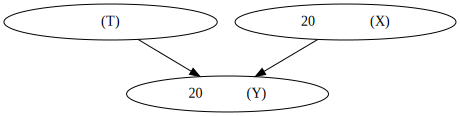

In [97]:
g = gr.Digraph()
g.edge("出门是否购买补刀斧(T)", "玩家第20分钟经济(Y)")
g.edge("玩家前20分钟人头数(X)", "玩家第20分钟经济(Y)")
g

In [64]:
model = smf.ols('kills_20_min ~ begin_buy_quelling_blade', data=rank_dr_df).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.1444,0.129,24.406,0.000,2.892,3.397
begin_buy_quelling_blade,-0.0400,0.172,-0.233,0.816,-0.377,0.297


In [76]:
model_x = smf.ols('begin_buy_quelling_blade ~ kills_20_min', data=rank_dr_df).fit()
print(model_x.summary().tables[1])
model_y = smf.ols('gold_20_min ~ kills_20_min', data=rank_dr_df).fit()
print(model_y.summary().tables[1])

residuals = pd.DataFrame(dict(res_y=model_y.resid, res_x=model_x.resid))
model_t = smf.ols('res_y ~ res_x', data=residuals).fit()

                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.5665      0.027     20.762      0.000       0.513       0.620
kills_20_min    -0.0016      0.007     -0.233      0.816      -0.015       0.012
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1483.8733     14.838    100.003      0.000    1454.749    1512.997
kills_20_min    49.1953      3.717     13.237      0.000      41.901      56.490


In [84]:
print("gold_20_min Variance", np.var(rank_dr_df["gold_20_min"]))
print("gold_20_min Residual Variance", np.var(residuals["res_y"]))

model_t.summary().tables[1]

gold_20_min Variance 87795.469739929
gold_20_min Residual Variance 72805.35698927521


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3.137e-13,9.030,-3.47e-14,1.000,-17.724,17.724
res_x,117.7269,18.199,6.469,0.000,82.006,153.448


In [85]:
model = smf.ols('gold_20_min ~ begin_buy_quelling_blade+kills_20_min', data=rank_dr_df).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1417.1797,17.791,79.656,0.000,1382.260,1452.099
begin_buy_quelling_blade,117.7269,18.210,6.465,0.000,81.985,153.469
kills_20_min,49.3825,3.631,13.602,0.000,42.256,56.509


In [92]:
model = smf.ols('gold_20_min ~ begin_buy_quelling_blade', data=rank_dr_df).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1572.4572,15.049,104.493,0.000,1542.921,1601.994
begin_buy_quelling_blade,115.7515,20.082,5.764,0.000,76.336,155.167


## 【不应该控制的变量】有能力预测X，但和Y关系不大

introduced MORE variance to our ATE estimator.

假设有一个特征和出门是否购买补刀斧高度相关，但和20分钟经济没啥关系。控制了这个特征之后，限制了「是否购买补刀斧」的变化范围（比如1000场里面，只有1场出了补刀斧），于是增加了评估因果关系的难度。